In [3]:
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# Load the data
data_dir = Path('~/model_outputs').expanduser()
# grab each subdirectory
model_dirs = [x for x in data_dir.iterdir() if x.is_dir()]
model_names = [x.name for x in model_dirs]
dataset_names = list(set(x.name for model_dir in model_dirs for x in model_dir.iterdir()))
model_names, dataset_names

(['SelFee-7b',
  'Qwen-7b',
  'Morph-7b-v0',
  'Gemma-2b-Instruct',
  'Tora-13b-v1.0',
  'Llama-2-13b',
  'Vicuna-13b-v1.5',
  'Tora-7b-v1.0',
  'LLeMMA-7b',
  'Deepseek-7b-Instruct',
  'Mistral-7b-Instruct-v0.2',
  'Vicuna-7b-v1.5',
  'Llama-2-7b',
  'Deepseek-7b-RL'],
 ['Geometry',
  'Prealgebra',
  'Number_Theory',
  'Counting_and_Probability',
  'GSM8K',
  'Intermediate_Algebra',
  'Precalculus',
  'Algebra'])

In [5]:
import json

# load the name maps
with open('name_maps.json', 'r') as f:
    name_maps = json.load(f)
    DATASET_MAP = name_maps['DATASET_MAP']
    MODEL_MAP = name_maps['MODEL_MAP']

In [6]:
%%capture
from dataset import from_name
from prompt import generate_nshot_prompts
from dataset import load_datasets, BOXED_ANSWERS_DATASETS

import numpy as np

datasets_raw = load_datasets(BOXED_ANSWERS_DATASETS)
datasets = {
    DATASET_MAP[dataset['name']]: dataset['data']['train']
    for dataset in datasets_raw
}

np.random.seed(0)
num_samples = 100
# datasets_subset = {k: np.random.choice(v, num_samples, replace=False) for k, v in datasets.items()}
datasets_subset = datasets

datasets = {k: list(v) for k, v in datasets.items()}

# prepend datasets_subset with 3 examples from datasets
# datasets_subset = {k: datasets[k][:3] + list(v) for k, v in datasets_subset.items()}

datas = {k: generate_nshot_prompts(v, n=3) for k, v in datasets_subset.items()}

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [5]:
import torch

torch.set_float32_matmul_precision('medium')

from comet import download_model, load_from_checkpoint

# model_path = download_model("Unbabel/XCOMET-XL")
model_path = download_model("Unbabel/wmt23-cometkiwi-da-xl")
model = load_from_checkpoint(model_path)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

checkpoints/model.ckpt:   0%|          | 0.00/13.9G [00:00<?, ?B/s]

Encoder model frozen.


In [15]:
import json
import os
from typing import List

from nltk.tokenize import sent_tokenize

from roscoe.score import (
    SEQ_EMB_MODEL_TYPES,
    Chain,
    Evaluator,
    REASONING_SCORES,
    UNSUPERVISED_SCORES,
    SENT_TRANS,
    SIMSCE
)
from roscoe.util import (
    print_and_reset_max_gpu_memory,
    save_scores,
    split_gsm8k_gpt3_generations_to_steps,
)


class ReasoningSteps(Chain):
    def __init__(self, line: str, type="regular") -> None:
        self.chain = self.parse_chain(line, type=type)

    def parse_chain(self, chain: str, type: str) -> List[str]:
        """
        Change formatting.

        Returns list of steps in reasoning chain.
        """
        if type == "gsm8k_ref":
            return chain.split("IGNORE THIS. Ground truth here for reference. ")[
                1
            ].split('\n')
        elif type == "gsm8k_hypo":
            return split_gsm8k_gpt3_generations_to_steps(reasoning=chain)
        elif type == "regular":
            return sent_tokenize(chain)
        else:
            raise NotImplementedError(f"{type} chain type is not supported")

In [194]:
# get memory usage of evaluator.ppl_model
param_size = 0
for param in evaluator.grmr_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in evaluator.grmr_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024 ** 3
print('model size: {:.3f}GB'.format(size_all_mb))

model size: 1.324GB


In [ ]:
from roscoe.score import Evaluator

evaluator = Evaluator(
    score_types=REASONING_SCORES,
    model_type=SIMSCE,
    transformer_model="facebook/roscoe-512-roberta-base",
    ppl_model="gpt2-large",
    discourse_batch=64,
    coherence_batch=16,
    hypos=[],
    context=[],
)

In [40]:
len(evaluator.hypos), len(evaluator.context), len(evaluator.references)

(866, 866, 100)

In [79]:
def get_nshot_base_question(question):
    return question.split('4.')[-1].strip()


def compute_roscoe(outputs, solutions):
    # hypos is the predicted reasoning chain
    hypos = [
        ReasoningSteps(o.outputs[0].text)
        for o in outputs
    ]
    # refs is the ground truth reasoning chain
    refs = [
        ReasoningSteps(s['answer'] if isinstance(s, dict) else s)
        for s in solutions
    ]
    # context is the prompt
    context = [
        ReasoningSteps(get_nshot_base_question(o.prompt))
        for o in outputs
    ]

    # x = [get_nshot_base_question(s['question']) for s in solutions]
    # y = [get_nshot_base_question(o.prompt) for o in outputs]
    # print(len(hypos), len(refs), len(context))
    # print(x[:2])
    # print('=' * 20)
    # print(y[:2])
    # raise ValueError
    # evaluate
    n = 50
    evaluator.set_hypos(hypos[:n])
    evaluator.set_references(refs[:n])
    evaluator.set_context(context[:n])
    scores = evaluator.evaluate()
    return dict(scores)

# roscoe_res = {
#     dataset: compute_roscoe(pickle.load(open(subdir / "deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl", 'rb'))[0], datas[dataset.replace(' ', '_')])
#     for dataset, subdir in zip(dataset_names, subdirs)
# }

In [67]:
with open('/lfs/skampere1/0/kaif/generated_outputs/roscoe_temp.pkl', 'wb') as f:
    pickle.dump(roscoe_res, f)

In [6]:
# data = [
#     # {
#     #     "src": datas['Hendrycks Algebra'][0]['question'],
#     #     "mt": predictions[0].outputs[0].text,
#     #     "ref": datas['Hendrycks Algebra'][0]['answer']
#     # }
#     {
#         "src": d['question'],
#         "mt": o.outputs[0].text,
#         "ref": d['answer']
#     } for d, o in zip(datas['Hendrycks Algebra'], predictions)
# ]
# model_output = model.predict(data, batch_size=64, gpus=1)
# # Segment-level scores
# print (model_output.scores)
#
# # System-level score
# print (model_output.system_score)
#
# # Score explanation (error spans)
# print (model_output.metadata.error_spans)

def comet(outputs, solutions, use_ref=True):
    if use_ref:
        data = [
            {
                "src": o.prompt,
                "mt": o.outputs[0].text,
                "ref": sol
            } for (sol, o) in zip(solutions, outputs)
        ]
    else:
        data = [
            {
                "src": o.prompt,
                "mt": o.outputs[0].text
            } for o in outputs
        ]
    model_output = model.predict(data, batch_size=16, gpus=1)
    return model_output


import pickle

# xcomet_res = {
#     dataset: xcomet(pickle.load(open(subdir / "deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl", 'rb'))[0], datas[dataset])
#     for dataset, subdir in zip(dataset_names, subdirs)
# }

In [7]:
# # save
# with open('/lfs/skampere1/0/kaif/generated_outputs/xcom_temp.pkl', 'wb') as f:
#     pickle.dump(xcomet_res, f)
# load
with open('/lfs/skampere1/0/kaif/generated_outputs/xcom_temp.pkl', 'rb') as f:
    xcomet_res = pickle.load(f)

In [10]:
xcomet_res['Hendrycks Number Theory'][0]

[-0.020785126835107803,
 0.4671115279197693,
 0.10703986883163452,
 0.21691416203975677,
 0.4291362762451172,
 0.15880897641181946,
 0.10980308055877686,
 0.3915104269981384,
 0.1625659018754959,
 0.17447619140148163,
 0.2452925592660904,
 0.0959959477186203,
 0.5035491585731506,
 0.28316664695739746,
 0.23006048798561096,
 0.44405701756477356,
 0.5198138952255249,
 0.0679740160703659,
 0.2654409110546112,
 0.23506446182727814,
 0.2610689401626587,
 0.04608777165412903,
 0.33572155237197876,
 0.12029794603586197,
 0.04577001929283142,
 0.10286605358123779,
 0.18454307317733765,
 0.09765969961881638,
 0.038985442370176315,
 0.1381720006465912,
 -0.017582610249519348,
 0.24566973745822906,
 0.2083980143070221,
 0.03989856690168381,
 0.13172371685504913,
 0.0803569108247757,
 0.18906089663505554,
 0.15350253880023956,
 0.09212826937437057,
 0.09804103523492813,
 0.3993917405605316,
 0.39813321828842163,
 0.2272261679172516,
 0.15256209671497345,
 0.08622626960277557,
 0.15907545387744904,

In [6]:
import pickle

x = pickle.load(open(
    "/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl",
    'rb'))

In [61]:
subdirs[
    0] / "deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl", "/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl"

(PosixPath('/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_number_theory/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl'),
 '/lfs/skampere1/0/kaif/generated_outputs/EleutherAI_hendrycks_math_algebra/deepseek-ai_deepseek-math-7b-instruct_autoregressive.pkl')

In [68]:
from grader import ExactMatchGrader, NextTokenAccuracyGrader
from dataset import get_boxed_answer
from latex_formater import latex_deformat


def grade_predictions(outputs, data):
    grader = ExactMatchGrader()

    boxed_predictions = []
    for o in outputs:
        try:
            boxed_predictions.append(latex_deformat(get_boxed_answer(o.outputs[0].text)))
        except:
            print(get_boxed_answer(o.outputs[0].text))

    # boxed_predictions = [latex_deformat(get_boxed_answer(o.outputs[0].text)) for o in outputs]
    boxed_answers = [latex_deformat(get_boxed_answer(d)) for d in data]
    grades = grader.grade(boxed_predictions, boxed_answers)

    return grades

In [69]:
def teacher_forcing_accuracy(predictions, solutions):
    grader = NextTokenAccuracyGrader()
    return grader.grade(predictions, solutions)

In [288]:
model_names

['SelFee-7b',
 'Qwen-7b',
 'Morph-7b-v0',
 'Gemma-2b-Instruct',
 'Tora-13b-v1.0',
 'Llama-2-13b',
 'Vicuna-13b-v1.5',
 'Tora-7b-v1.0',
 'LLeMMA-7b',
 'Deepseek-7b-Instruct',
 'Mistral-7b-Instruct-v0.2',
 'Vicuna-7b-v1.5',
 'Llama-2-7b',
 'Deepseek-7b-RL']

In [325]:
# examine some of the predictions
def get_predictions(model, dataset, data_type):
    model_dir = data_dir / model
    dataset_dir = model_dir / dataset
    file = dataset_dir / f"{data_type}.pkl"
    with open(file, 'rb') as f:
        predictions, solutions = pickle.load(f)
    return predictions, solutions

predictions, solutions = get_predictions('LLeMMA-7b', 'Algebra', 'autoregressive')

Llama-2-13b tends to have a bunch of whitespace and ORs in the predictions.
Tora-13b-v1.0 lots of code and repeated sections. Probably hard to parse into steps

In [324]:
i = 0
print(get_nshot_base_question(predictions[i].prompt))
print('=' * 20)
print(solutions[i])
print('=' * 20)
print(predictions[i].outputs[0].text)

Sam is hired for a 20-day period. On days that he works, he earns $\$$60. For each day that he does not work, $\$$30 is subtracted from his earnings. At the end of the 20-day period, he received $\$$660. How many days did he not work?
Call $x$ the number of days Sam works and $y$ the number of days he does not. We can set up the following system of equations to represent the given information: \begin{align*}
x+y &= 20 \\
60x - 30y &= 660 \\
\end{align*} The first equation represents the total number of days Sam works, and the second equation represents his total profit. Solving for $x$ in the first equation yields $x = 20 - y$. Substituting into the second equation gives $60(20-y) - 30y = 660$. Canceling a factor of $10$ and multiplying out gives $120 - 6y - 3y = 66$. This simplifies to $-9y = -54$, or $y = 6$. Thus, Sam did not work for $\boxed{6}$ days.


Let $w$ represent the number of days Sam worked and $n$ represent the number of days he did not work. We know that $w + n = 20$ (s

In [295]:
root_dir = Path('/lfs/skampere1/0/kaif/model_outputs')
for model_dir in root_dir.iterdir():
    any_ouputs = False
    for dataset_dir in model_dir.iterdir():
        num_files = len(list(dataset_dir.iterdir()))
        if num_files != 0:
            any_ouputs = True
    if not any_ouputs:
        print(f"Empty directory: {model_dir}")

Empty directory: /lfs/skampere1/0/kaif/model_outputs/SelFee-7b
Empty directory: /lfs/skampere1/0/kaif/model_outputs/Qwen-7b
Empty directory: /lfs/skampere1/0/kaif/model_outputs/Gemma-2b-Instruct
Empty directory: /lfs/skampere1/0/kaif/model_outputs/Llama-2-7b


In [184]:
import pickle
import numpy as np
from tqdm.auto import tqdm

HOOKS = {
    'autoregressive': {
        'Accuracy': grade_predictions,
        'ROSCOE': compute_roscoe,
        # 'XCOMET': comet
    }
    # 'teacher_forcing': {}
}


def ensure_dict_path(d, path):
    """
    Ensure that the path exists in the dictionary
    """
    for key in path:
        if key not in d:
            d[key] = {}
        d = d[key]


def eval_data(data_dir):
    evals = {}
    number_of_models = len(list(data_dir.iterdir()))
    number_of_metrics = sum(len(metrics) for metrics in HOOKS.values())
    with (
        tqdm(total=number_of_models, desc='Models') as model_tqdm,
        tqdm(total=0, desc='Dataset') as data_tqdm,
        tqdm(total=number_of_metrics, desc='Metric') as metric_tqdm
    ):
        for model_dir in data_dir.iterdir():
            model_name = model_dir.name
            model_tqdm.set_description(model_name)
            data_tqdm.reset(total=len(list(model_dir.iterdir())))

            for dataset_dir in model_dir.iterdir():
                dataset_name = dataset_dir.name
                data_tqdm.set_description(dataset_name)
                metric_tqdm.reset()

                for data_type, metrics in HOOKS.items():
                    for metric_name, metric in metrics.items():
                        metric_tqdm.set_description(metric_name)
                        file = dataset_dir / f"{data_type}.pkl"
                        if file.exists():
                            with open(file, 'rb') as f:
                                predictions, solutions = pickle.load(f)
                                metric_value = metric(predictions, solutions)

                                if isinstance(metric_value, dict):
                                    for k, v in metric_value.items():
                                        sub_metric_name = f"{metric_name}_{k}"
                                        ensure_dict_path(evals, [sub_metric_name, dataset_name, model_name])
                                        evals[sub_metric_name][dataset_name][model_name] = v
                                else:
                                    ensure_dict_path(evals, [metric_name, dataset_name, model_name])
                                    evals[metric_name][dataset_name][model_name] = metric_value
                        metric_tqdm.update(1)
                data_tqdm.update(1)
            model_tqdm.update(1)

    return evals


evals = eval_data(root_dir)

Models:   0%|          | 0/14 [00:00<?, ?it/s]

Dataset: 0it [00:00, ?it/s]

Metric:   0%|          | 0/2 [00:00<?, ?it/s]




  0%|                                                                        | 0/16 [00:00<?, ?it/s]


  6%|████                                                            | 1/16 [00:00<00:01,  7.86it/s]


 12%|████████                                                        | 2/16 [00:00<00:01,  7.89it/s]


 25%|████████████████                                                | 4/16 [00:00<00:01, 11.73it/s]


 50%|████████████████████████████████                                | 8/16 [00:00<00:00, 19.11it/s]


 62%|███████████████████████████████████████▍                       | 10/16 [00:00<00:00, 15.42it/s]


 75%|███████████████████████████████████████████████▎               | 12/16 [00:00<00:00, 14.42it/s]


 88%|███████████████████████████████████████████████████████▏       | 14/16 [00:01<00:00, 12.42it/s]


100%|███████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.18it/s]



  0%|                                                                

In [260]:
evals.keys()

dict_keys(['Accuracy', 'ROSCOE_faithfulness', 'ROSCOE_informativeness_step', 'ROSCOE_informativeness_chain', 'ROSCOE_faithfulness_ww', 'ROSCOE_repetition_word', 'ROSCOE_repetition_step', 'ROSCOE_reasoning_alignment', 'ROSCOE_external_hallucination', 'ROSCOE_redundancy', 'ROSCOE_common_sense_error', 'ROSCOE_missing_step', 'ROSCOE_semantic_coverage_step', 'ROSCOE_semantic_coverage_chain', 'ROSCOE_discourse_representation', 'ROSCOE_coherence_step_vs_step', 'ROSCOE_perplexity_step', 'ROSCOE_perplexity_chain', 'ROSCOE_perplexity_step_max', 'ROSCOE_grammar_step', 'ROSCOE_grammar_step_max'])

In [7]:
import pickle
save_path = Path('/lfs/skampere1/0/kaif/generated_outputs/metrics/evals_roscoe.pkl')
# save_path.parent.mkdir(parents=True, exist_ok=True)
# with open(save_path, 'wb') as f:
#     pickle.dump(evals, f)
with open(save_path, 'rb') as f:
    evals = pickle.load(f)

In [8]:
for metric, datasets in evals.items():
    for dataset, models in datasets.items():
        for model, value in models.items():
            try:
                x = np.mean(value)
            except:
                print(len([v for v in value if isinstance(v, float)]),
                      np.mean([v for v in value if isinstance(v, float)]), metric, dataset, model)
                if len([v for v in value if isinstance(v, float)]) == 0:
                    print(value)
                    print('=' * 20)

49 0.8405970506506354 ROSCOE_faithfulness Prealgebra Llama-2-13b
45 0.8467352430587941 ROSCOE_faithfulness Prealgebra Vicuna-13b-v1.5
46 0.8619582814968522 ROSCOE_faithfulness Prealgebra Vicuna-7b-v1.5
49 0.8324291630869136 ROSCOE_faithfulness Geometry Morph-7b-v0
40 0.838231484716359 ROSCOE_faithfulness Geometry Vicuna-13b-v1.5
35 0.8521445494272787 ROSCOE_faithfulness Geometry Vicuna-7b-v1.5
48 0.8445453613000508 ROSCOE_faithfulness Intermediate_Algebra Llama-2-13b
26 0.8501560684006948 ROSCOE_faithfulness Intermediate_Algebra Vicuna-13b-v1.5
49 0.8373345136828682 ROSCOE_faithfulness Intermediate_Algebra Deepseek-7b-Instruct
40 0.8418717191627042 ROSCOE_faithfulness Intermediate_Algebra Vicuna-7b-v1.5
31 0.8555655749856621 ROSCOE_faithfulness Counting_and_Probability Vicuna-13b-v1.5
49 0.8254197339987245 ROSCOE_faithfulness Counting_and_Probability Deepseek-7b-Instruct
37 0.8577744394344953 ROSCOE_faithfulness Counting_and_Probability Vicuna-7b-v1.5
49 0.8300605343855131 ROSCOE_faith

In [270]:
roscoe_avg

{'Prealgebra': {'Morph-7b-v0': [1.162803352109238,
   1.2635953751943736,
   1.183395368682947,
   1.3292570368072438,
   1.2800786414176777,
   1.5782168807828665,
   1.0934601597194546,
   1.1701501593927217,
   1.1400833033098459,
   1.173845756977359,
   1.0661581169016165,
   1.33774731398035,
   1.1190066024420193,
   1.106843637861429,
   1.2973664722826082,
   1.03979044924944,
   1.1895705595880917,
   1.0781696707768422,
   1.1519437557203764,
   1.2495276293942805,
   1.3175660754702752,
   1.2776655188679986,
   1.006430971381762,
   1.2173401317716295,
   1.0240125043491188,
   1.0660698414108818,
   1.1004953020766404,
   1.224057927458943,
   1.260614535084431,
   1.0079436367947117,
   1.3296096620516897,
   1.0823780106940706,
   1.14015959154908,
   1.1964148157082808,
   1.0813140006180828,
   1.3529278819241446,
   1.3613828265559034,
   1.2169430472287899,
   1.0738206328173807,
   1.2564253287095304,
   1.2478633534454888,
   1.0964378440591838,
   1.2741242929164

In [9]:
import pandas as pd

def sum_values(a, b):
    a = [v if isinstance(v, float | bool) else 0 for v in a]
    b = [v if isinstance(v, float | bool) else 0 for v in b]
    return [x + y for x, y in zip(a, b)]

# compute average of all metrics with ROSCOE in their name
roscoe_avg = {}
n = 0
for metric, datasets in evals.items():
    if 'ROSCOE' in metric:
        n += 1
        roscoe_avg = {
            dataset: {
                model: sum_values(v, roscoe_avg.get(dataset, {}).get(model, [0] * len(v)))
                for model, v in models.items()
            }
            for dataset, models in datasets.items()
        }
roscoe_avg = {
    dataset: {
        model: [v / n for v in value]
        for model, value in models.items()
    }
    for dataset, models in roscoe_avg.items()
}
evals['ROSCOE'] = roscoe_avg

evals_avg = {
    metric: {
        model: {
            dataset: np.mean([v for v in value if isinstance(v, float | bool)])
            for dataset, value in datasets.items()
        }
        for model, datasets in models.items()
    }
    for metric, models in evals.items()
}

evals_dfs = {
    metric: pd.DataFrame(v).melt(value_name=metric, var_name='dataset',
        ignore_index=False).reset_index(names='model')
    for metric, v in evals_avg.items()
}

In [13]:
plt.close()

In [ ]:
# plot histograms for each metric, model, dataset conditioned on accuracy
def plot_histograms(evals, metric, model, dataset, ax):
    # check to see if dataset and model are in evals
    ax.set_title(f"{model} {dataset}")
    if dataset not in evals[metric] or model not in evals[metric][dataset]:
        return
    metric_data = evals[metric][dataset][model]
    metric_data = [m if isinstance(m, float | bool) else -0.5 for m in metric_data]
    accuracy_data = evals['Accuracy'][dataset][model]
    metric_correct = [m for m, a in zip(metric_data, accuracy_data) if a]
    metric_incorrect = [m for m, a in zip(metric_data, accuracy_data) if not a]
    ax.hist(metric_correct, bins=20, alpha=0.5, label='Correct')
    ax.hist(metric_incorrect, bins=20, alpha=0.5, label='Incorrect')
    # set x ticks to be the same
    ax.set_xticks(np.linspace(-0.5, 1, 5))
    ax.legend()

# plot_histograms(evals, 'ROSCOE', 'Deepseek-7b-Instruct', 'Algebra', plt.gca())
# plt.show()


for metric in evals_dfs.keys():
    fig, axs = plt.subplots(len(model_names), len(dataset_names), figsize=(len(model_names) * 4, len(dataset_names) * 8))
    for i, model in enumerate(model_names):
        for j, dataset in enumerate(dataset_names):
            plot_histograms(evals, metric, model, dataset, axs[i, j])
    plt.savefig(f'plots/hist_{metric}.png')
    plt.close()

In [278]:
# merge all the dataframes in evals_dfs
from functools import reduce
df = reduce(lambda x, y: pd.merge(x, y, on=['dataset', 'model']), evals_dfs.values())
for metric in evals_dfs.values():
    assert df.shape[0] == metric.shape[0]


# compute R^2 of each metric against Accuracy conditioned on model (use .corr().iloc[0, 1] ** 2)
R2_model = {
    metric: df.groupby('model').apply(lambda x: x[['Accuracy', metric]].corr().iloc[0, 1] ** 2)
    for metric in evals_dfs.keys()
}
R2_dataset = {
    metric: df.groupby('dataset').apply(lambda x: x[['Accuracy', metric]].corr().iloc[0, 1] ** 2)
    for metric in evals_dfs.keys()
}
import seaborn as sns

sns.set_theme(style="whitegrid")

# g = sns.lmplot(
#     data=df,
#     x='Teacher Forced Cross Entropy',
#     y='Accuracy',
#     hue='model',
#     col='dataset',
#     col_wrap=3,
#     height=4,
#     aspect=1,
#     scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
#     palette='tab10',
# )
# g.set(xscale="log", yscale="log")

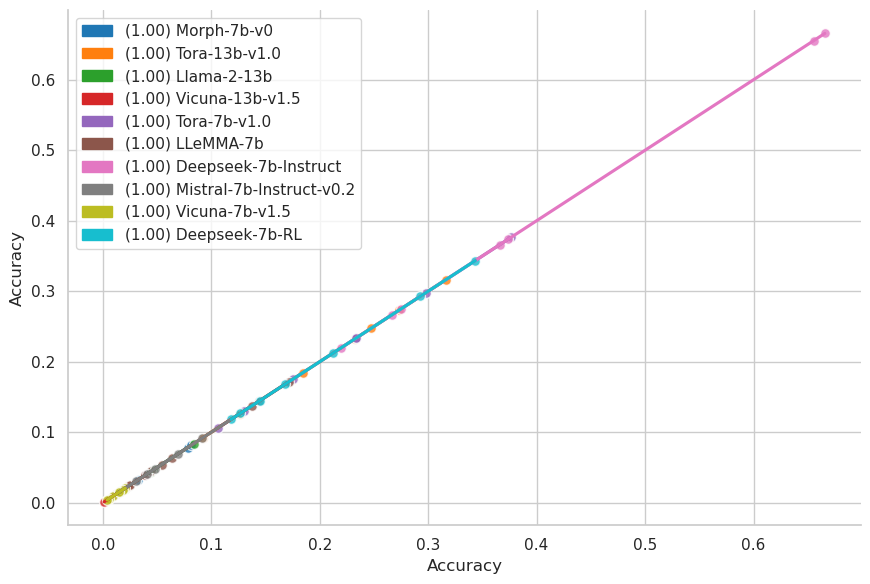

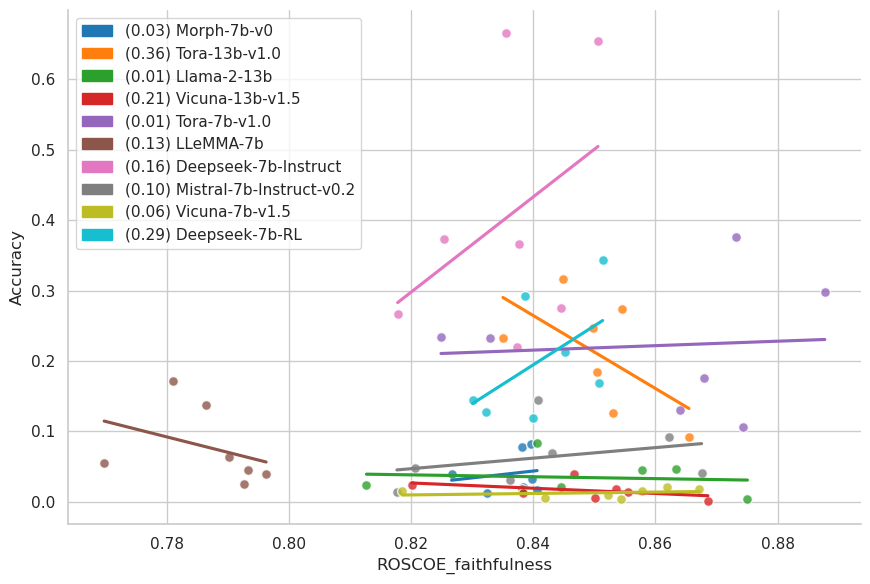

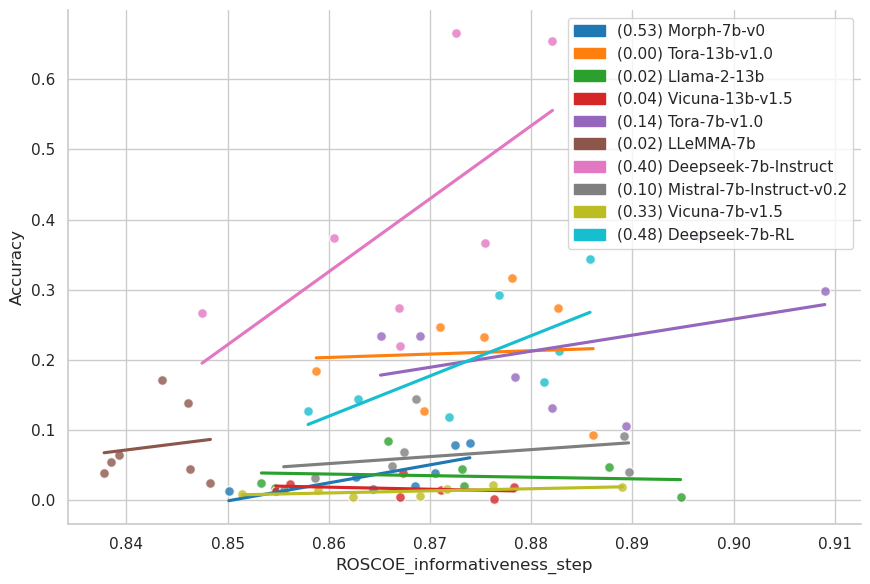

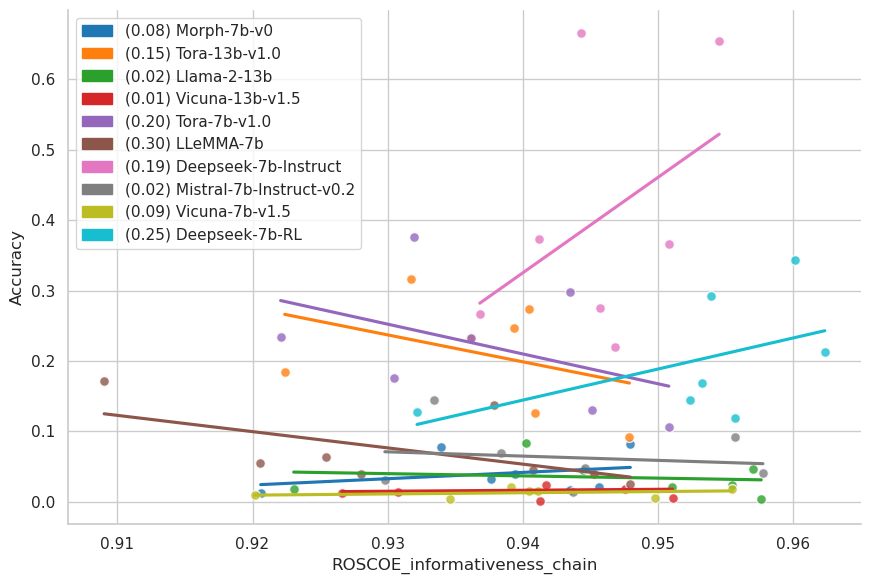

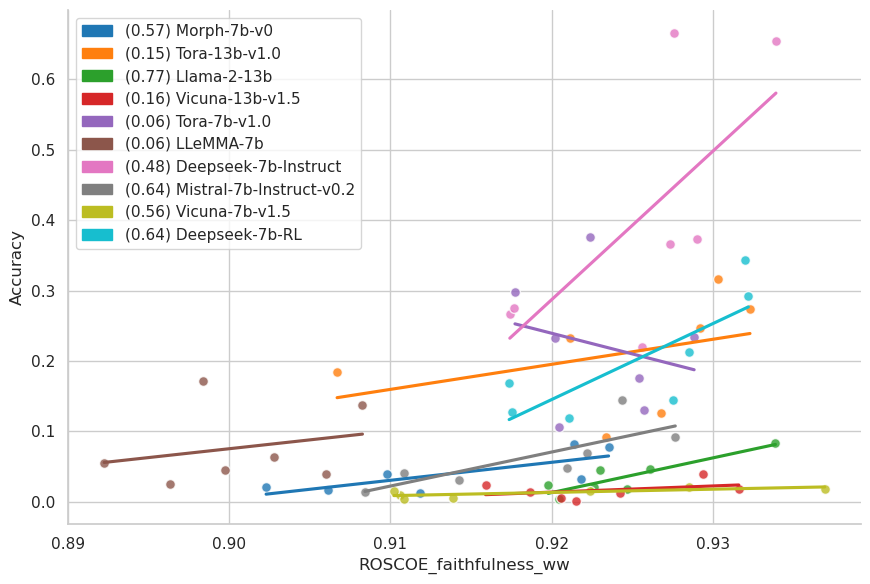

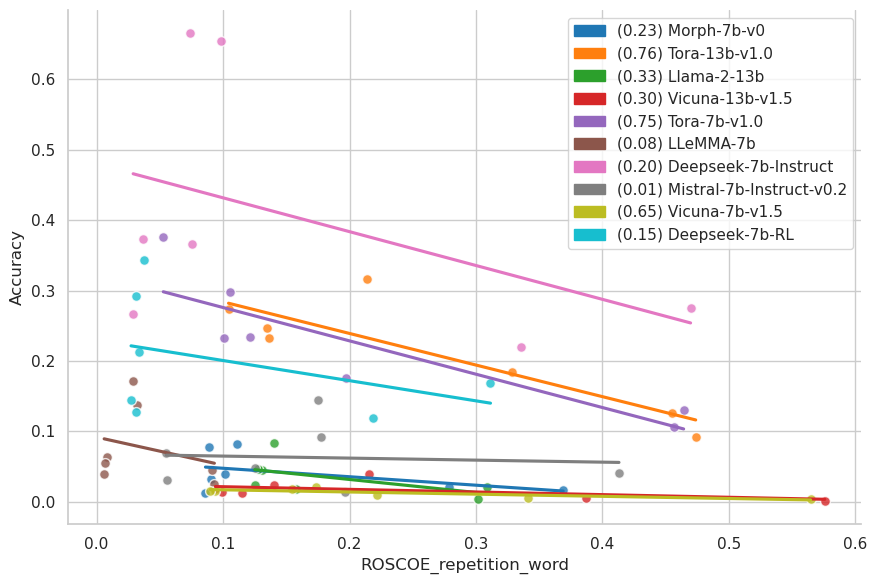

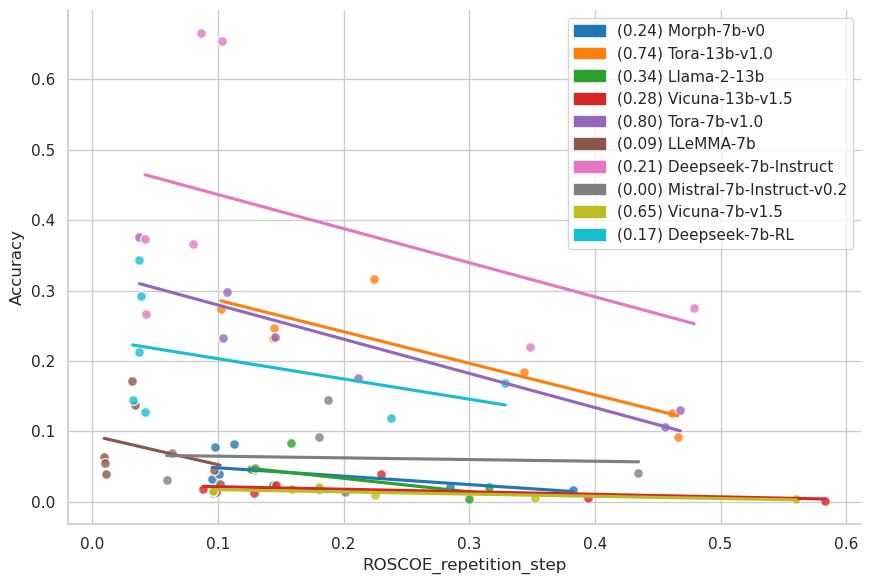

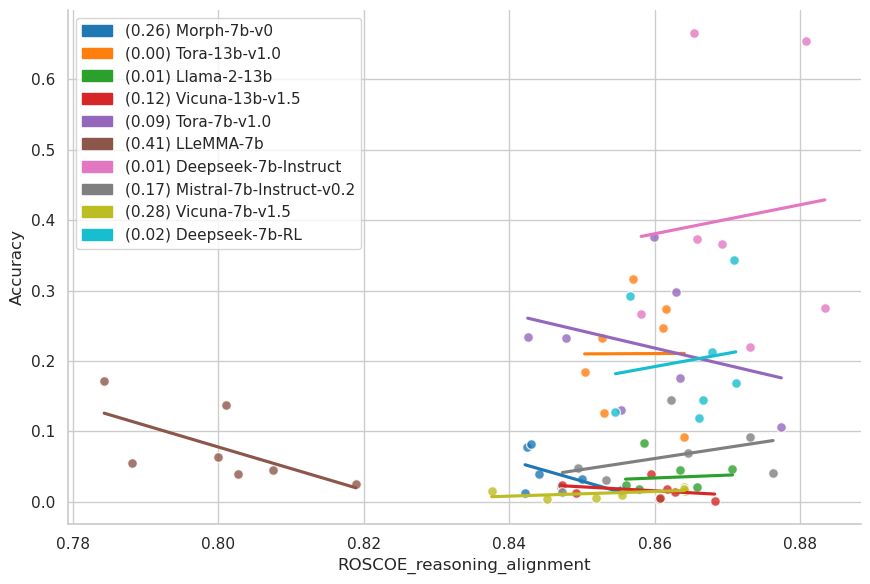

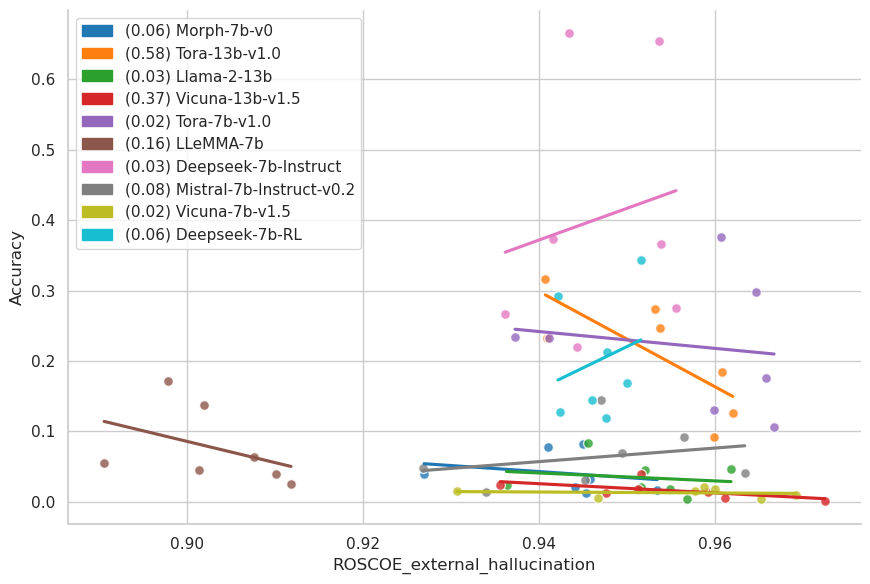

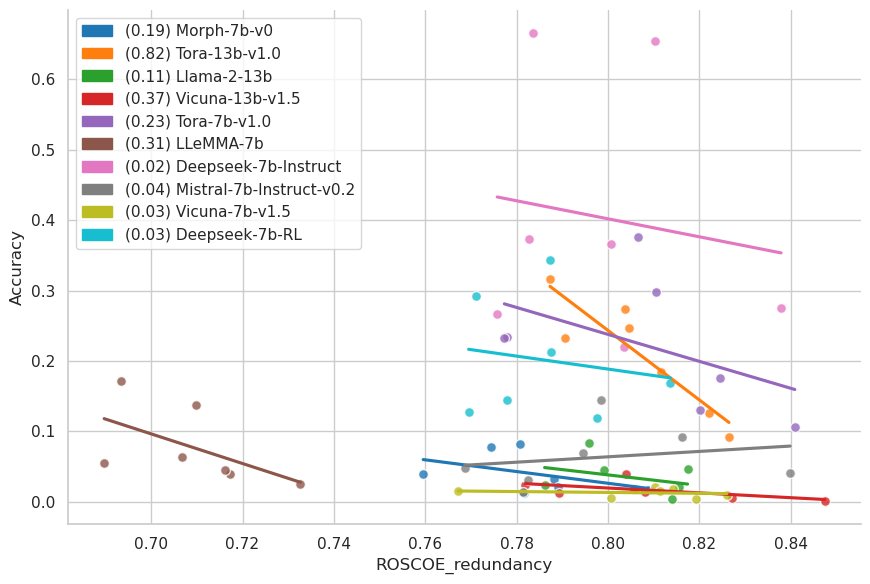

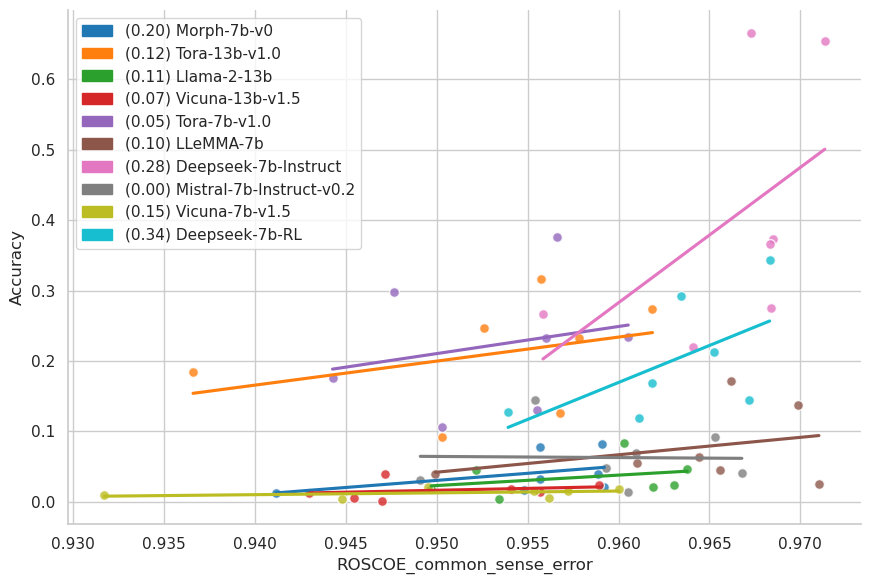

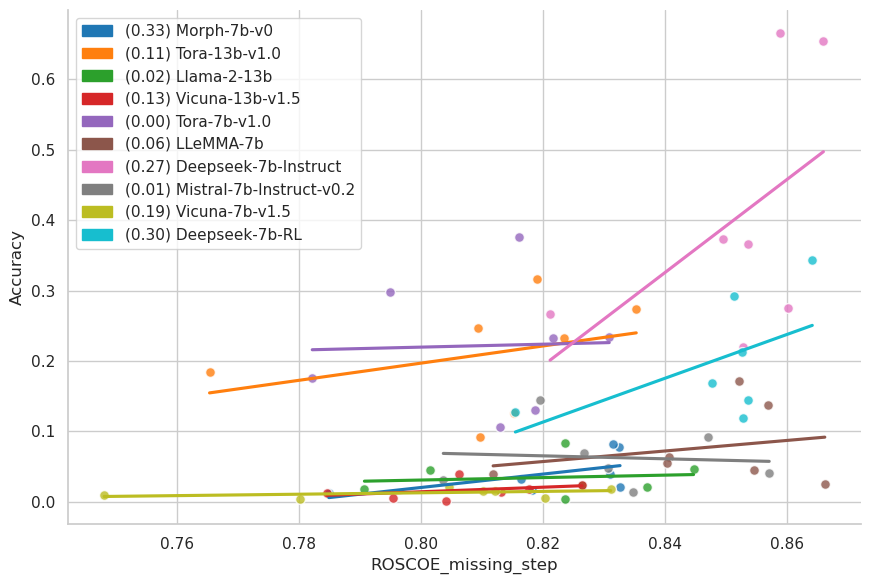

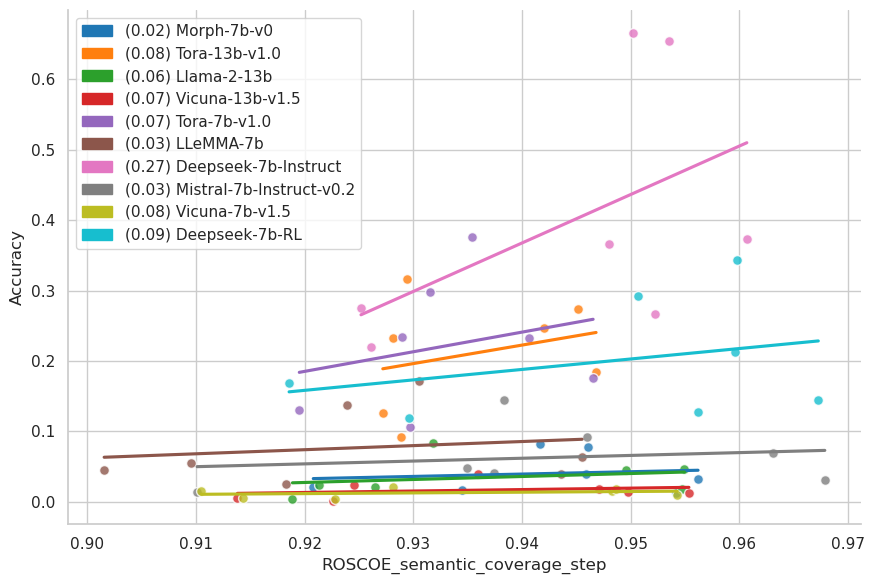

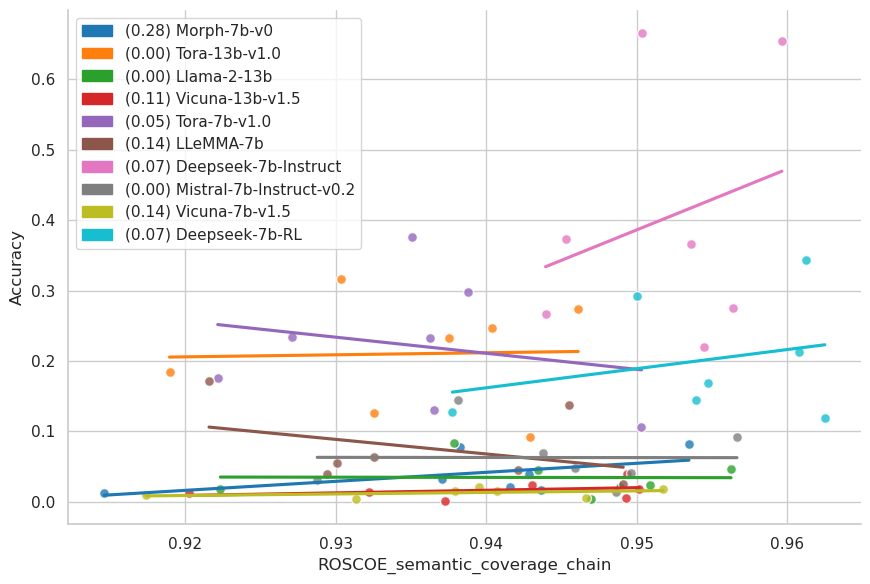

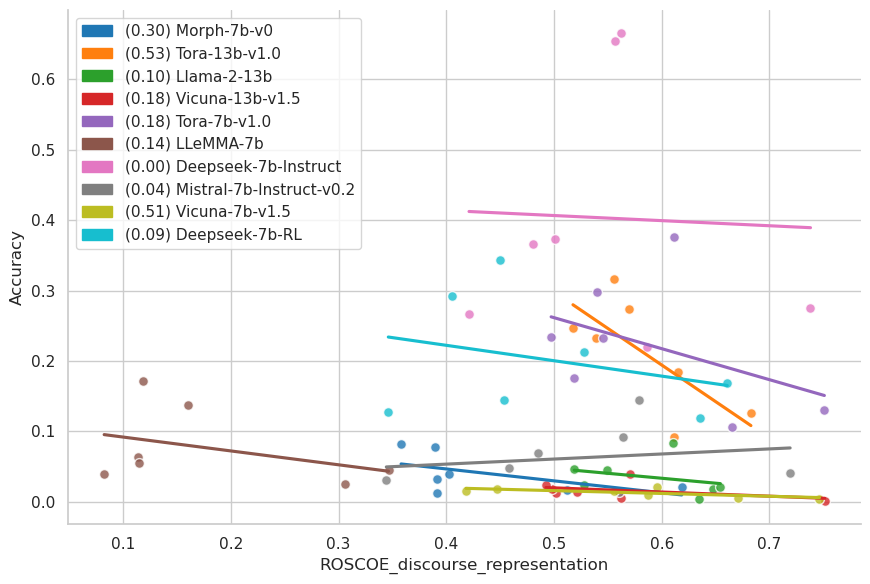

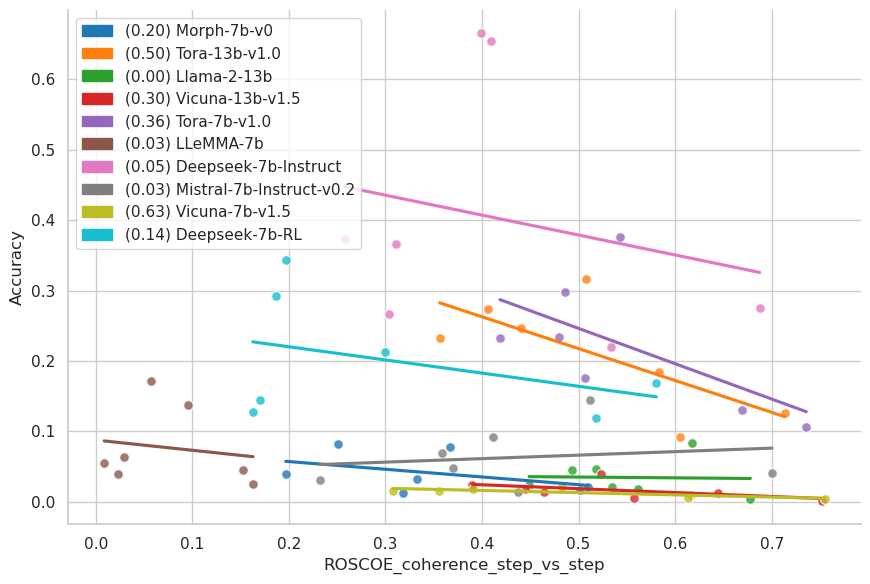

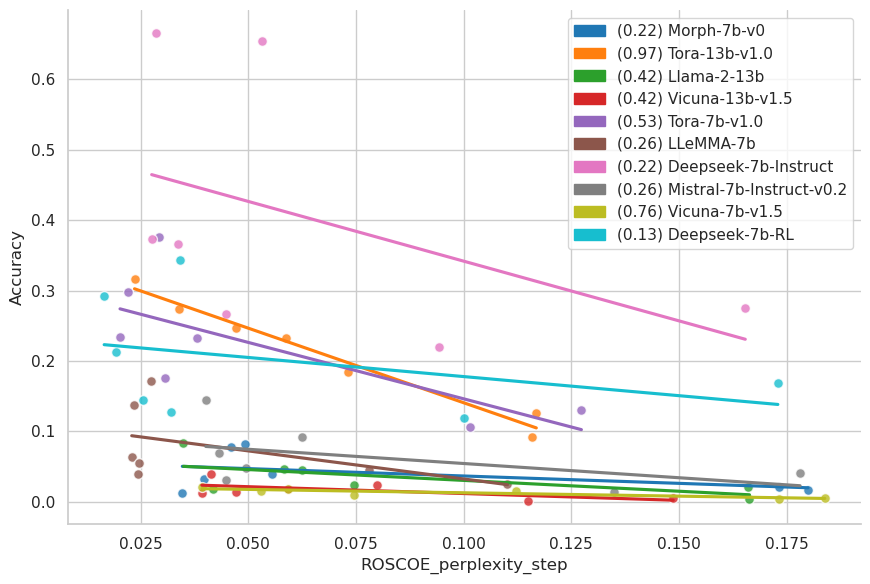

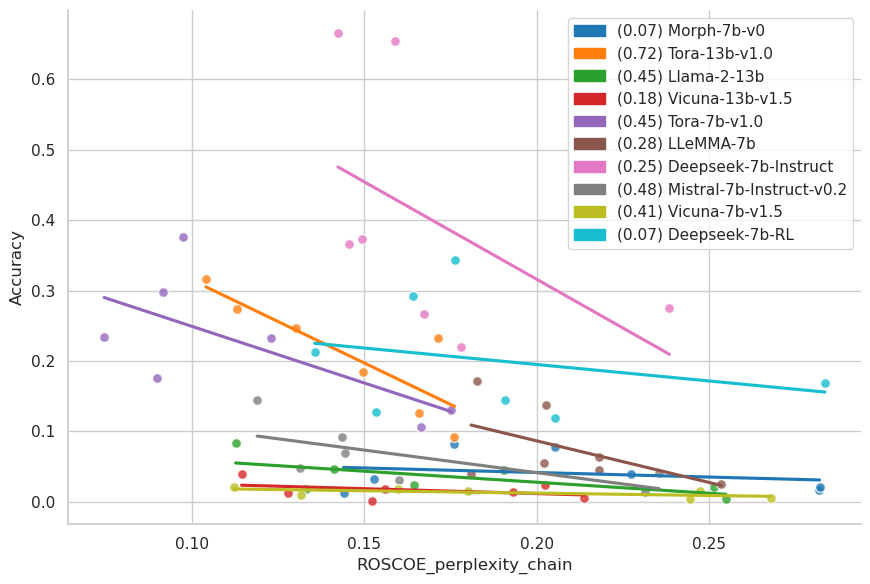

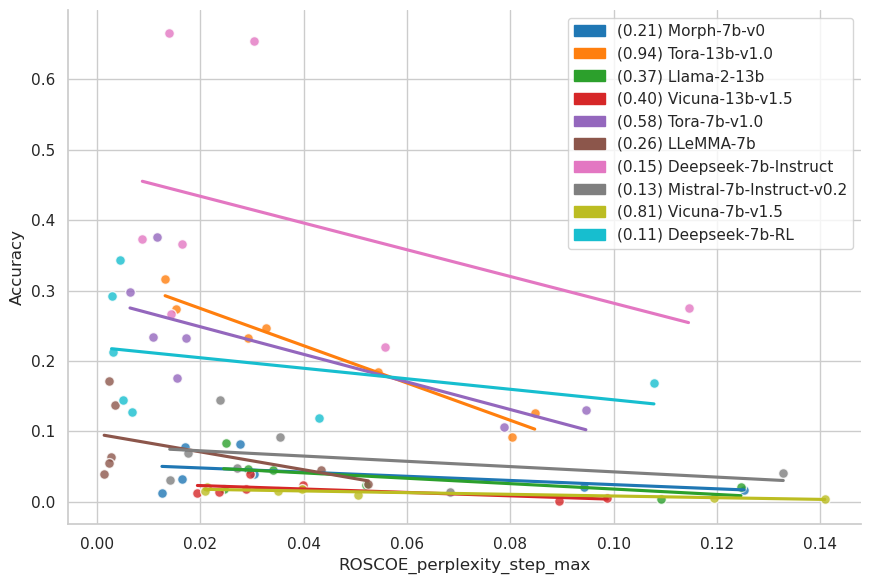

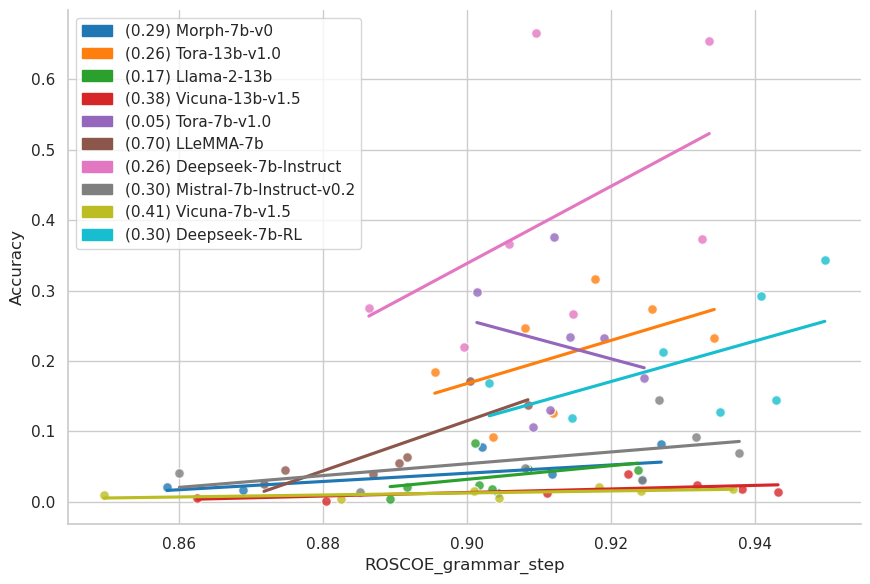

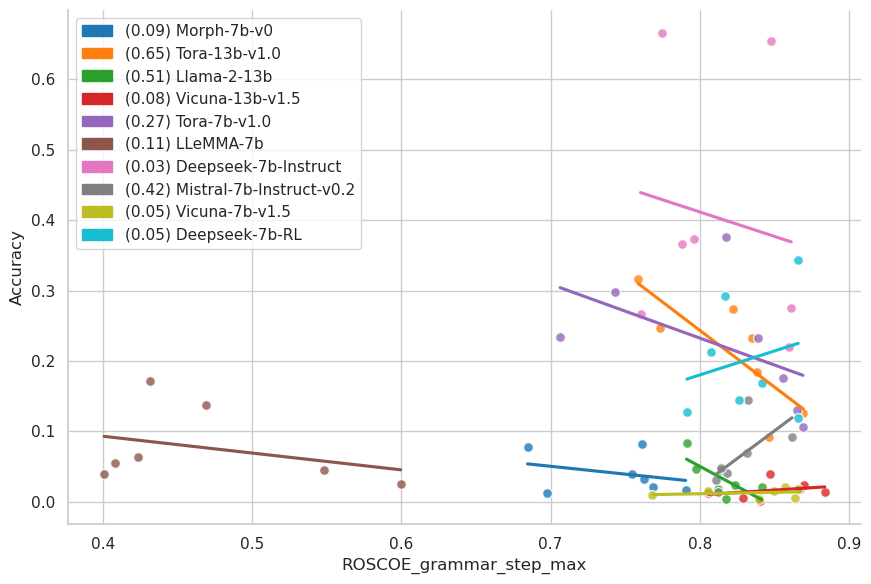

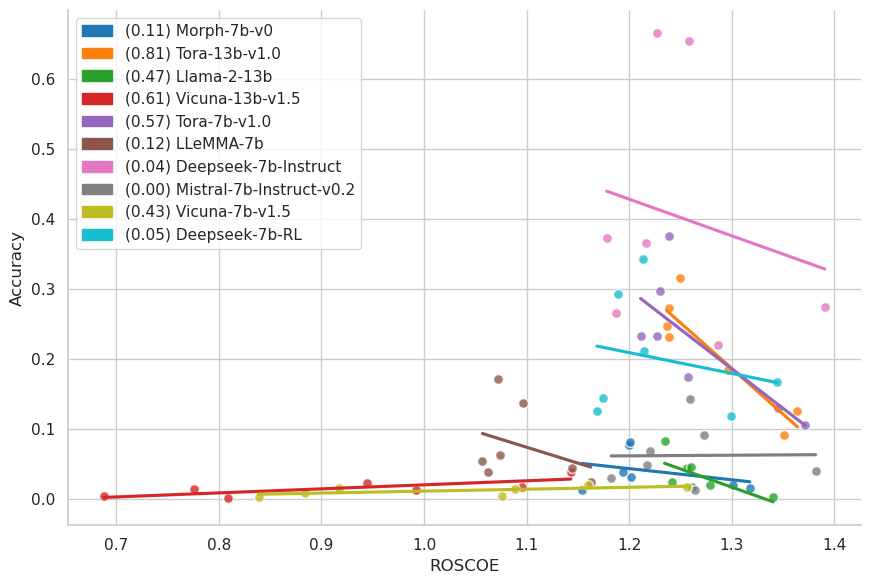

In [296]:
# # put R2 next to model name in legend
# # df['Log Accuracy'] = np.log(df['Accuracy'])
# xcom_corr = df.groupby('model').apply(lambda x: x[['COMETKIWI', 'Accuracy']].corr().iloc[0, 1] ** 2)
#
# g = sns.lmplot(
#     data=df,
#     x='COMETKIWI',
#     y='Accuracy',
#     hue='model',
#     height=6,
#     aspect=1.5,
#     scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
#     palette='tab10',
#     # ci=None,
#     # legend=False,  # turn off the original legend
# )
#
# import matplotlib.patches as mpatches
#
# # Fetching the color palette based on the number of unique models
# color_palette = sns.color_palette('tab10', n_colors=len(df['model'].unique()))
#
# legend_patches = []
# for i, model in enumerate([l.get_text() for l in g.legend.texts]):
#     correlation = xcom_corr[model]
#     legend_patches.append(mpatches.Patch(color=color_palette[i],
#                                          label=f'({correlation:0.2f}) {model}'))
#
# g.legend.set_visible(False)
# plt.legend(handles=legend_patches)
# plt.show()
# # g.set(xscale="log", yscale="log")

# repeat above but for each df in evals_dfs
for metric, eval_df in evals_dfs.items():
    g = sns.lmplot(
        data=df,
        x=metric,
        y='Accuracy',
        hue='model',
        height=6,
        aspect=1.5,
        scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
        palette='tab10',
        ci=None,
        # legend=False,  # turn off the original legend
    )

    import matplotlib.patches as mpatches

    # Fetching the color palette based on the number of unique models
    color_palette = sns.color_palette('tab10', n_colors=len(df['model'].unique()))

    legend_patches = []
    for i, model in enumerate([l.get_text() for l in g.legend.texts]):
        correlation = R2_model[metric][model]
        legend_patches.append(mpatches.Patch(color=color_palette[i],
                                             label=f'({correlation:0.2f}) {model}'))

    g.legend.set_visible(False)
    plt.legend(handles=legend_patches)
    plt.show()

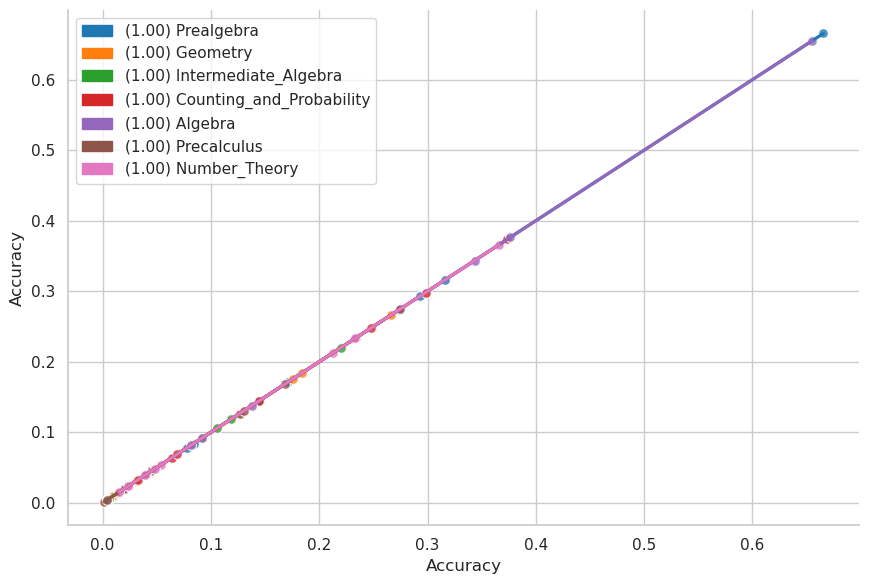

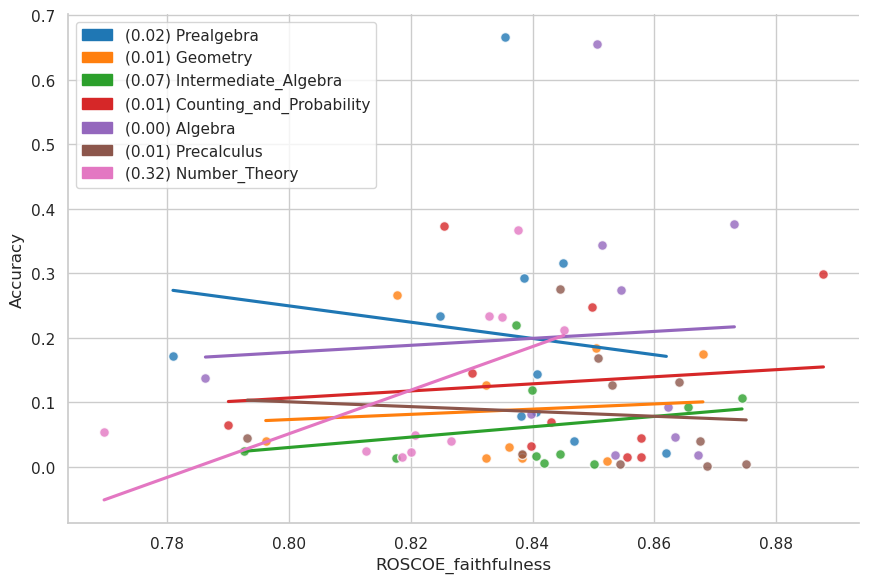

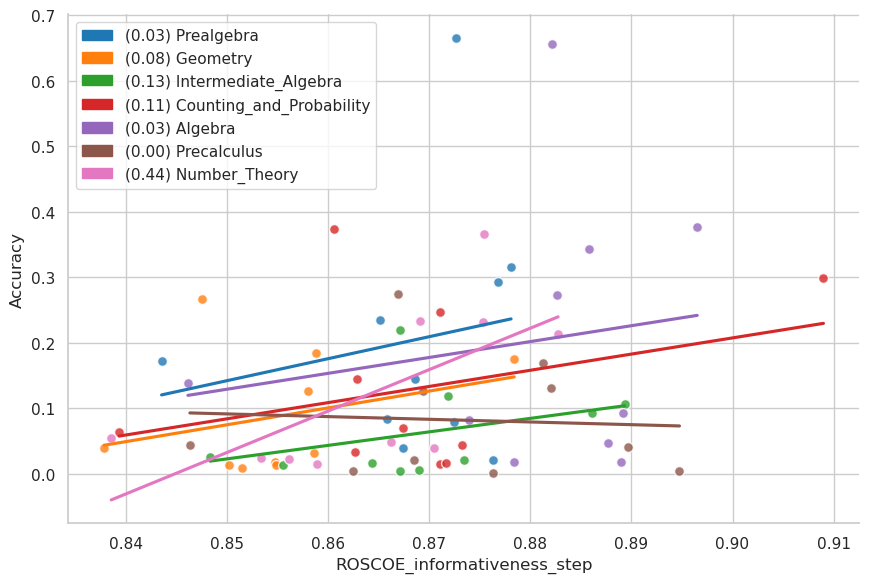

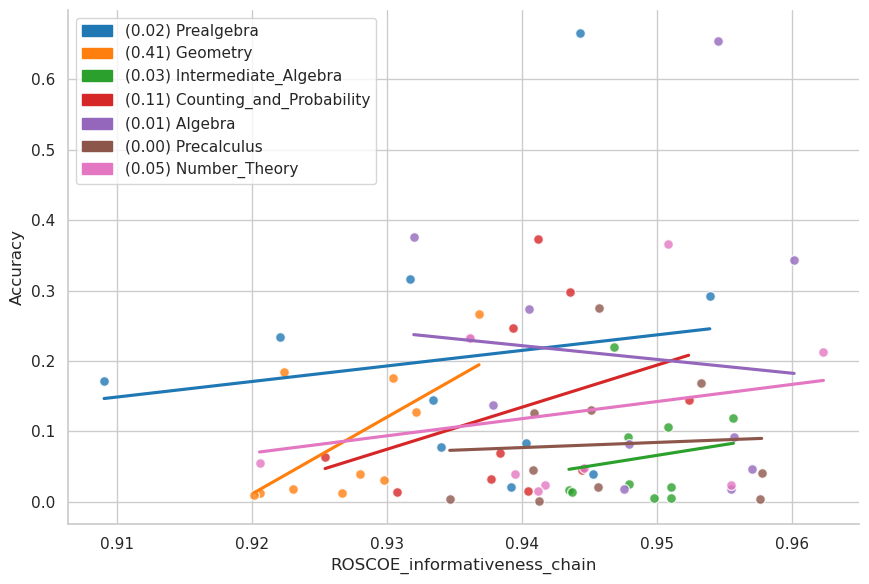

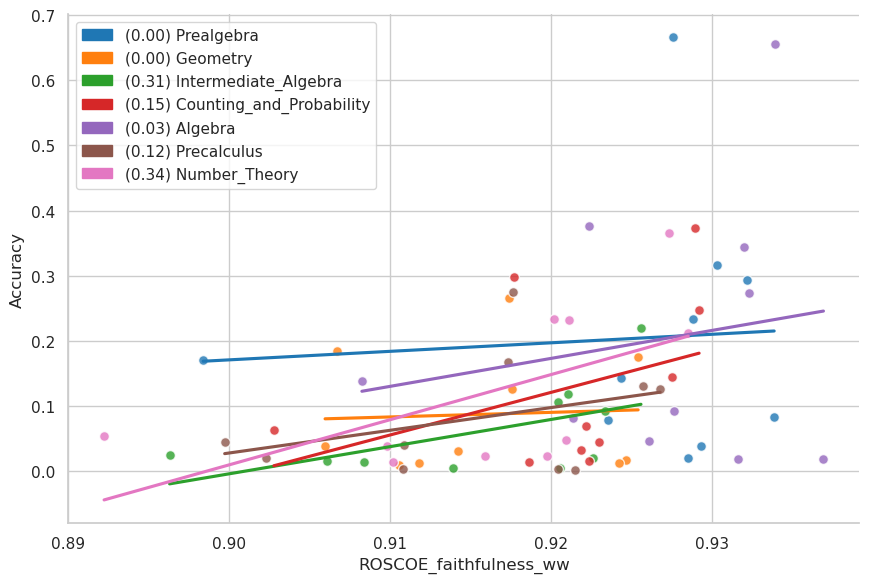

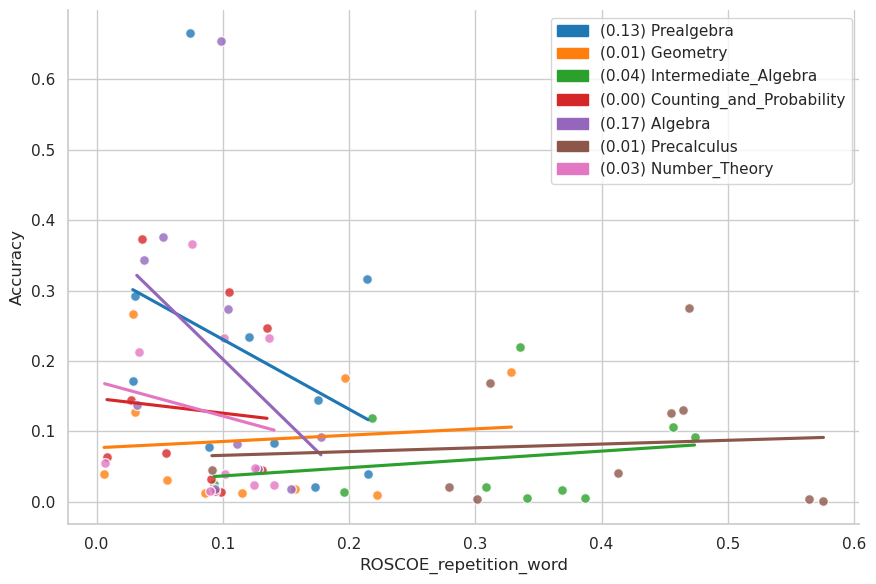

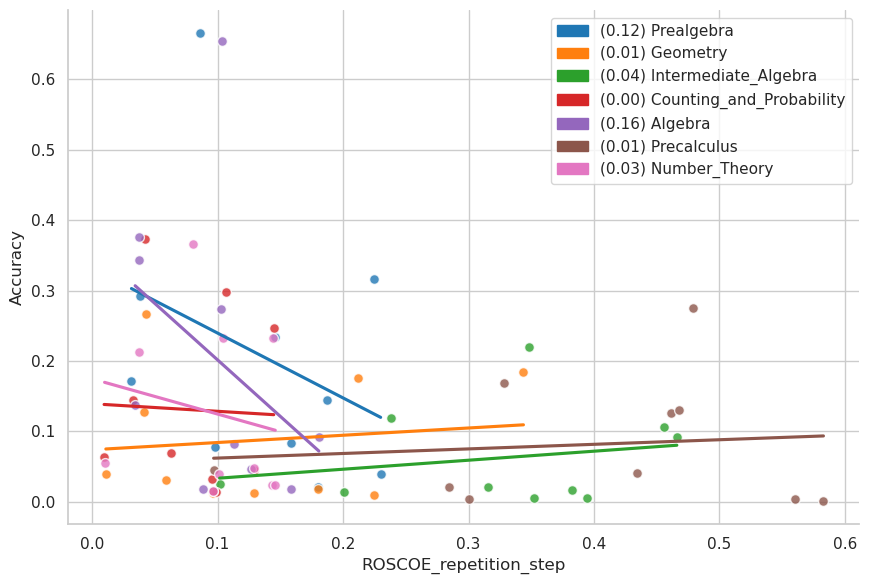

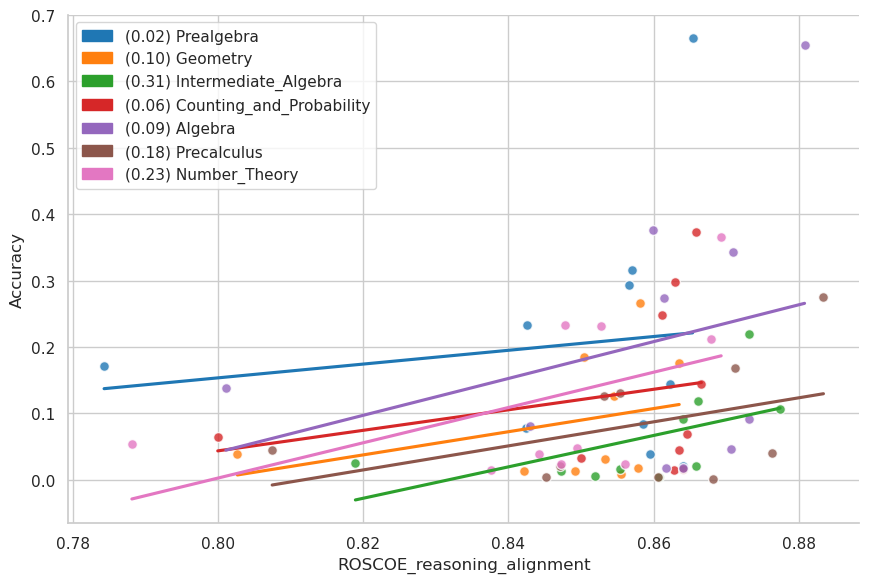

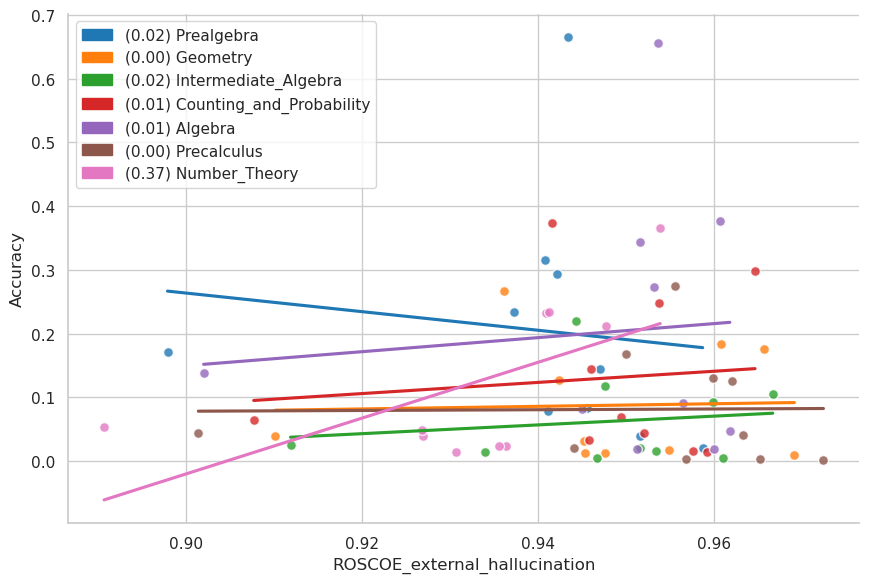

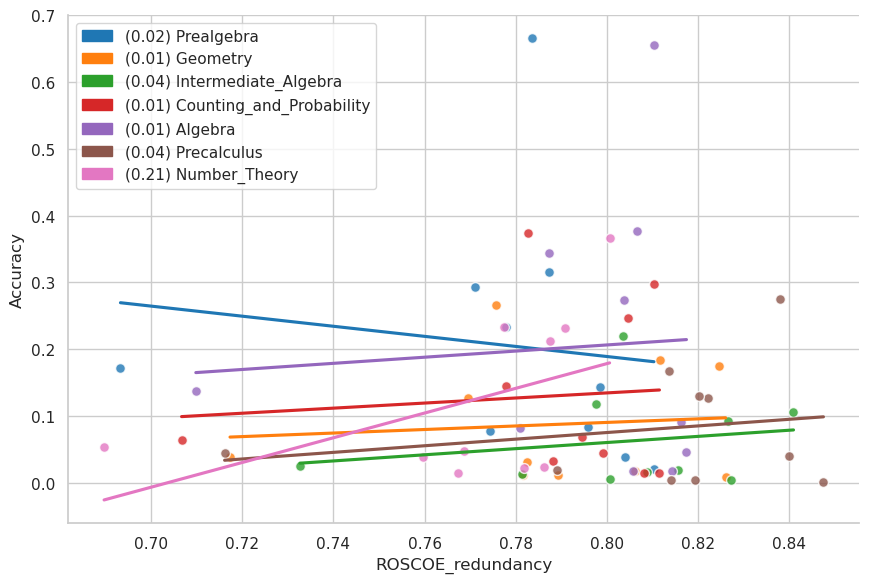

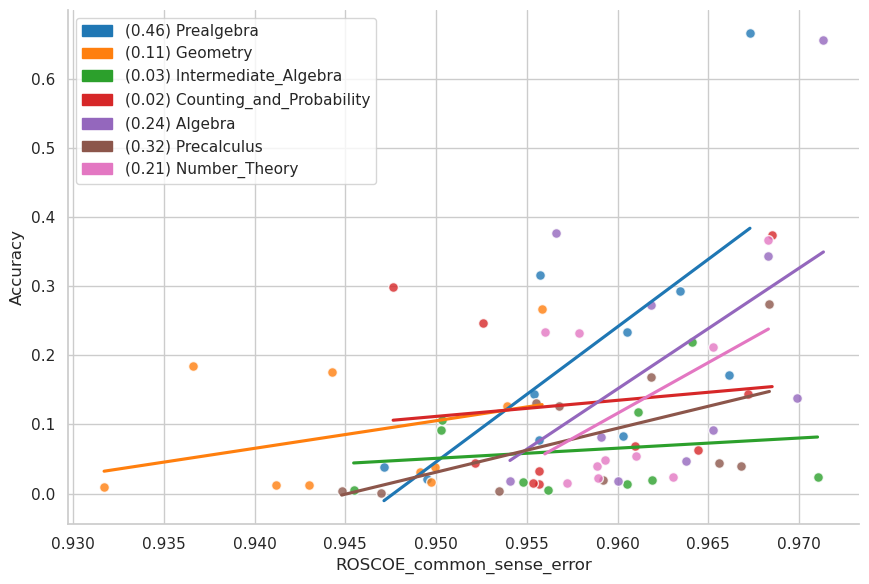

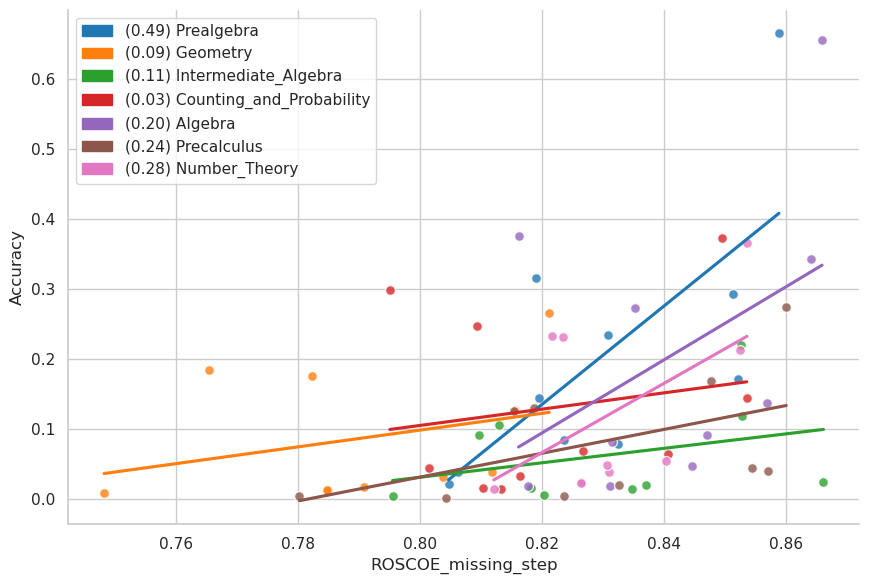

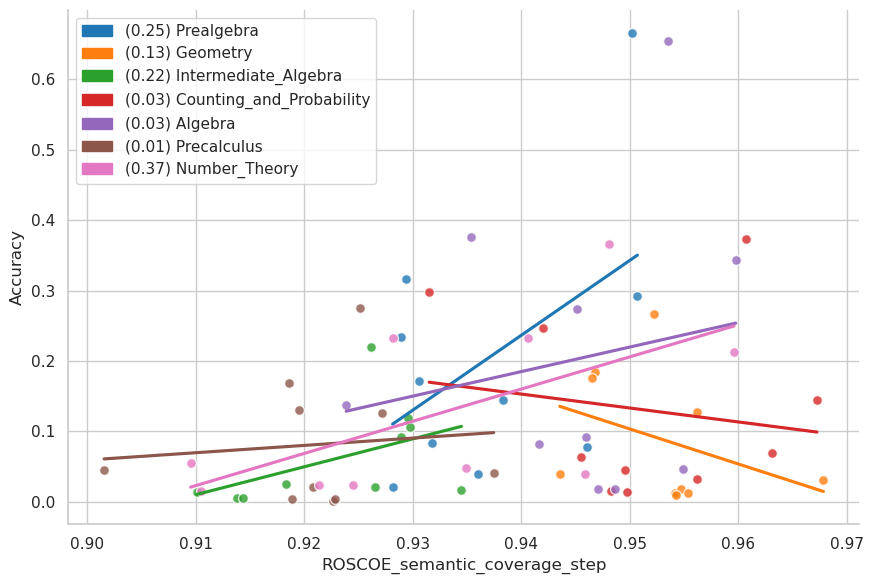

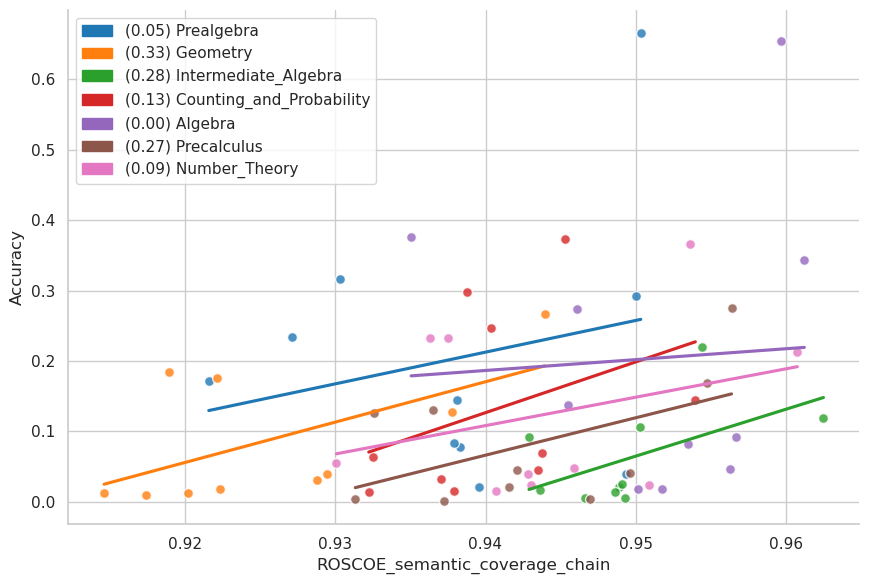

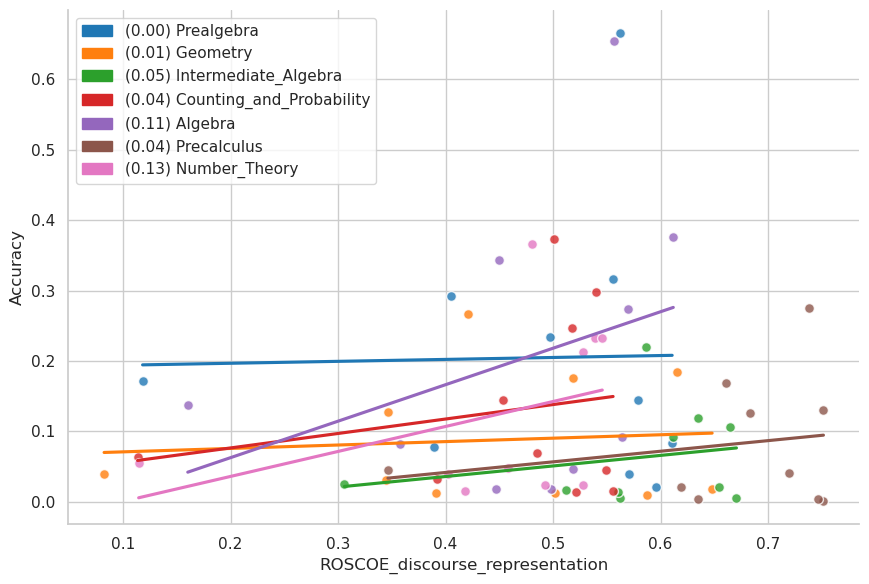

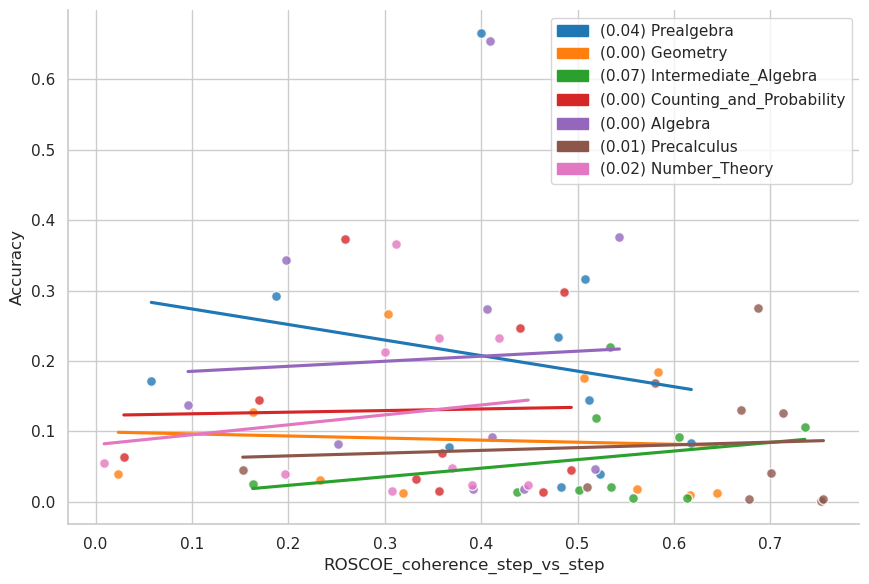

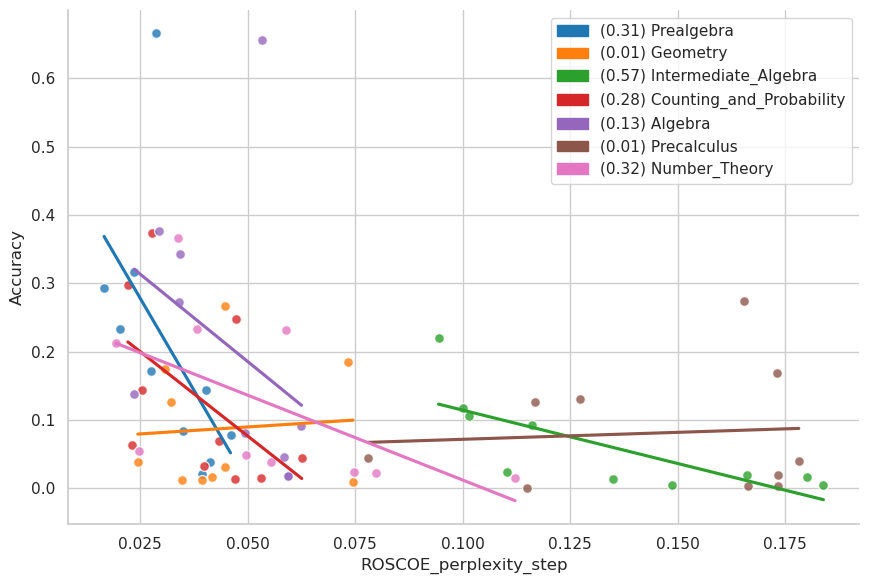

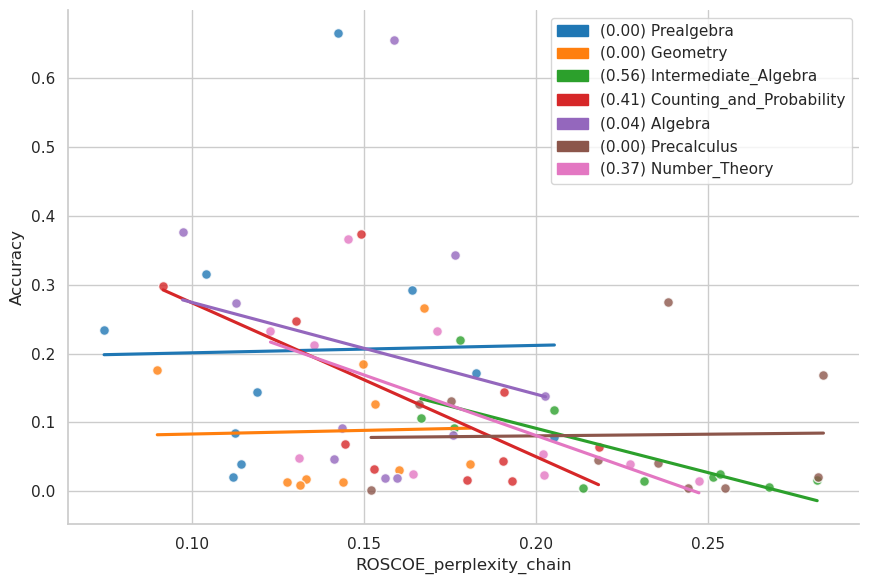

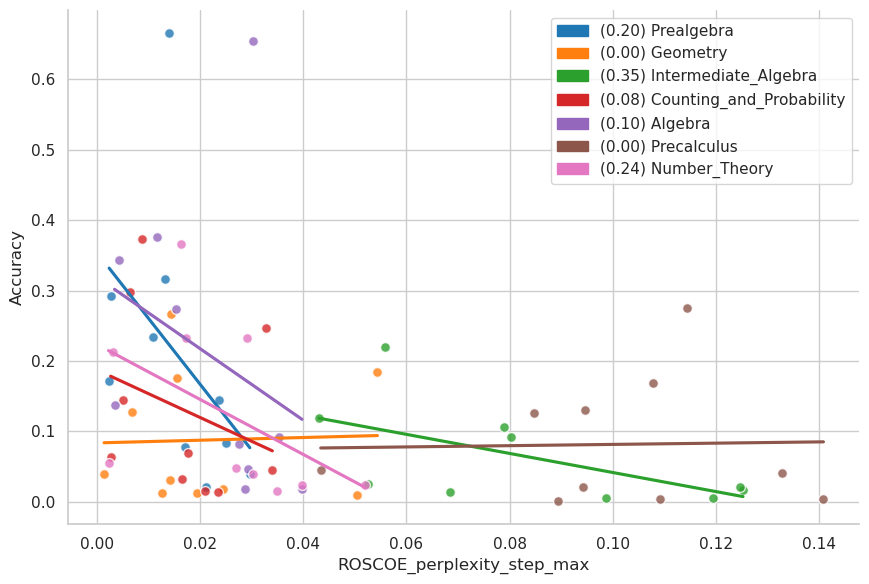

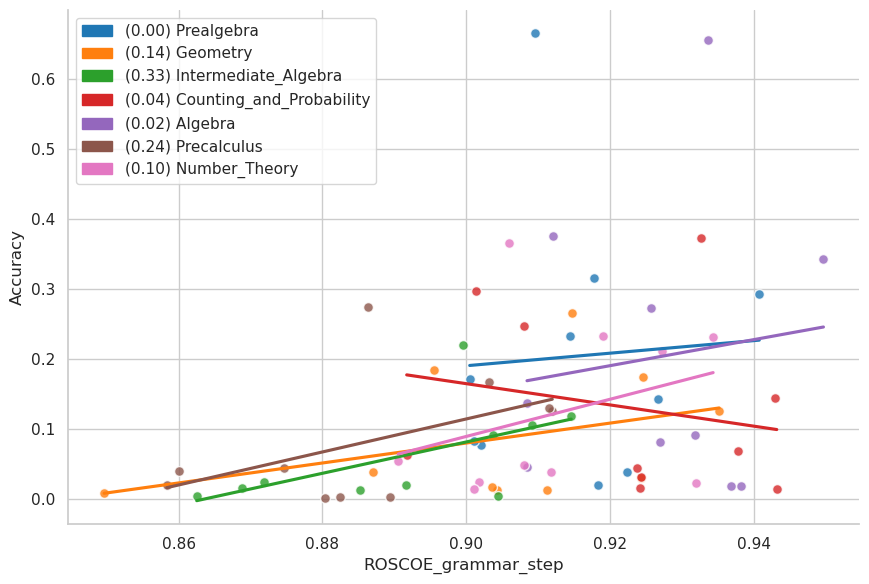

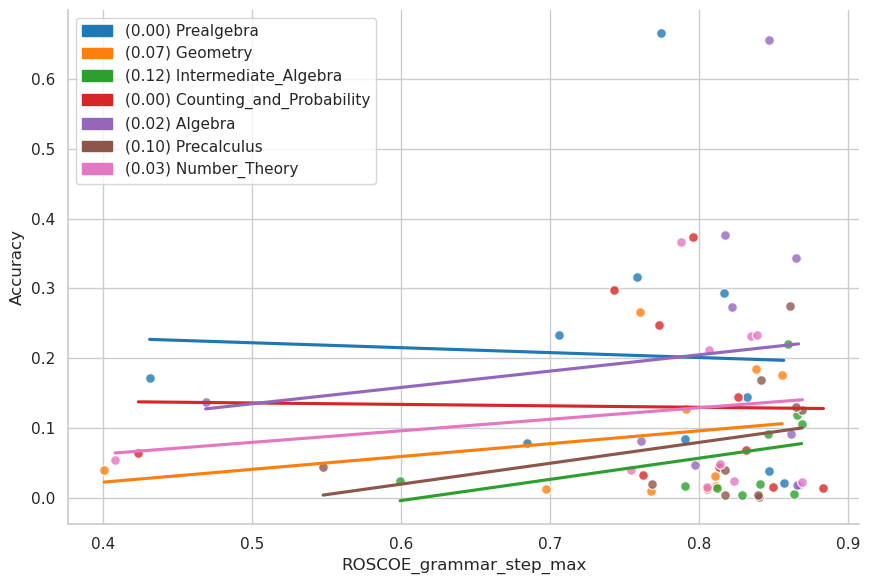

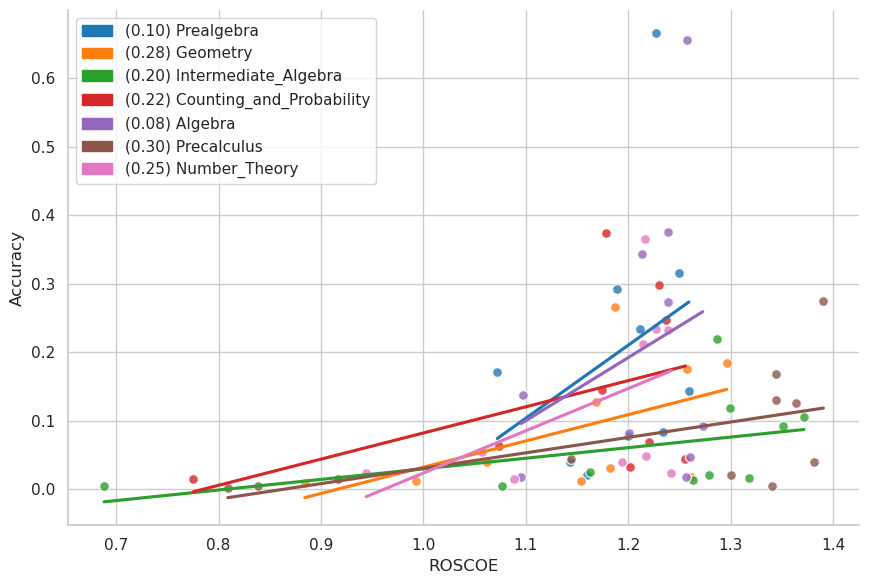

In [279]:
for metric, eval_df in evals_dfs.items():
    g = sns.lmplot(
        data=df,
        x=metric,
        y='Accuracy',
        hue='dataset',
        height=6,
        aspect=1.5,
        scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
        palette='tab10',
        ci=None,
        # legend=False,  # turn off the original legend
    )

    import matplotlib.patches as mpatches

    # Fetching the color palette based on the number of unique models
    color_palette = sns.color_palette('tab10', n_colors=len(df['dataset'].unique()))

    legend_patches = []
    for i, dataset in enumerate([l.get_text() for l in g.legend.texts]):
        correlation = R2_dataset[metric][dataset]
        legend_patches.append(mpatches.Patch(color=color_palette[i],
                                             label=f'({correlation:0.2f}) {dataset}'))

    g.legend.set_visible(False)
    plt.legend(handles=legend_patches)
    plt.show()

In [17]:
dir(g.legend)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alignment',
 '_alpha',
 '_animated',
 '_auto_legend_data',
 '_axes',
 '_bbox_to_anchor',
 '_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_custom_handler_map',
 '_default_handler_map',
 '_different_canvas',
 '_draggable',
 '_find_best_position',
 '_findoffset',
 '_fontsize',
 '_fully_clipped_to_axes',
 '_get_anchored_bbox',
 '_get_loc',
 '_gid',
 '_in_layout',
 '_init_legend_box',
 '_internal_update',
 '_label',
 '_legend_box',
 '_legend_handle_box',
 '_legend_title_box',
 '_loc',
 '_loc_real',
 '_loc_used_default',
 '_mode',
 '_mouseover',
 '_ncol

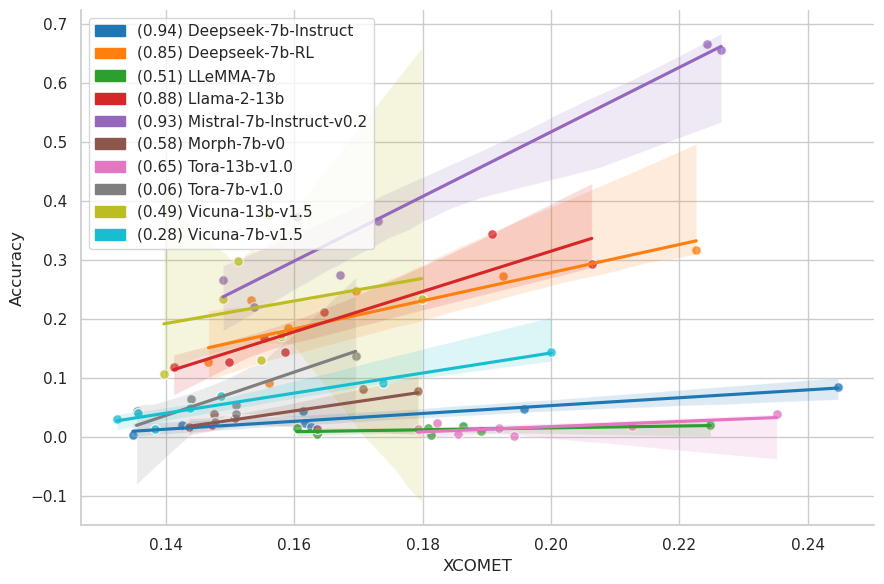

In [31]:
# put R2 next to model name in legend
# df['Log Accuracy'] = np.log(df['Accuracy'])
xcom_corr = df.groupby('model').apply(lambda x: x[['COMETKIWI', 'Accuracy']].corr().iloc[0, 1] ** 2)

g = sns.lmplot(
    data=df,
    x='COMETKIWI',
    y='Accuracy',
    hue='model',
    height=6,
    aspect=1.5,
    scatter_kws=dict(s=50, linewidths=1, edgecolor='w'),
    palette='tab10',
    legend=False,  # turn off the original legend
)

import matplotlib.patches as mpatches

# Fetching the color palette based on the number of unique models
color_palette = sns.color_palette('tab10', n_colors=len(df['model'].unique()))

legend_patches = []
for i, (model, correlation) in enumerate(zip(xcom_corr.index, xcom_corr)):
    legend_patches.append(mpatches.Patch(color=color_palette[i],
                                         label=f'({correlation:0.2f}) {model}'))

plt.legend(handles=legend_patches)
plt.show()
# g.set(xscale="log", yscale="log")

In [35]:
??corr_df.to_latex

In [36]:
# join correlation dataframes
corr_df = pd.concat([tfa_corr, tfce_corr], axis=1)
corr_df = corr_df.rename(columns={0: 'TFA', 1: 'TFCE'})
print(corr_df.to_latex())

\begin{tabular}{lrr}
\toprule
 & TFA & TFCE \\
model &  &  \\
\midrule
Deepseek-7b-Instruct & 0.439272 & 0.399167 \\
Deepseek-7b-RL & 0.285773 & 0.317733 \\
LLeMMA-7b & 0.100595 & 0.104666 \\
Mistral-7b-Instruct-v0.2 & 0.097707 & 0.131686 \\
Morph-7b-v0 & 0.060026 & 0.053734 \\
Tora-13b-v1.0 & 0.311476 & 0.389184 \\
Tora-7b-v1.0 & 0.376615 & 0.331863 \\
\bottomrule
\end{tabular}


In [70]:
??LinearRegression.score

In [93]:
# compute R^2
from sklearn.linear_model import LinearRegression

R2 = df.groupby('model').apply(
    lambda x: LinearRegression().fit(x[['Teacher Forced Accuracy']], x[['Accuracy']]).score(
        x[['Teacher Forced Accuracy']],
        x[['Accuracy']]))
R2

model
Deepseek-7b-Instruct    0.448161
Deepseek-7b-RL          0.364979
LLeMMA-7b               0.110630
Tora-13b-v1.0           0.490849
dtype: float64

In [58]:
# compute correlation between log accuracy and cross entropy
correlation = df.groupby('model').apply(lambda x: x[['Log Accuracy', 'Cross Entropy']].corr().iloc[0, 1])
correlation

model
EleutherAI_llemma_7b                     0.251294
deepseek-ai_deepseek-math-7b-instruct   -0.498419
deepseek-ai_deepseek-math-7b-rl         -0.221735
llm-agents_tora-13b-v1.0                -0.650091
dtype: float64

In [57]:
# compute correlation between grade and ppl
correlation = df.groupby('model').apply(lambda x: x[['grade', 'ppl']].corr().iloc[0, 1])
correlation

model
EleutherAI_llemma_7b                     0.165939
deepseek-ai_deepseek-math-7b-instruct   -0.471243
deepseek-ai_deepseek-math-7b-rl         -0.209154
llm-agents_tora-13b-v1.0                -0.646765
dtype: float64

In [59]:
# estimate the variance of the sample correlation
# using the Fisher transformation
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Testing_using_Statistical_Packages
n = df.groupby('model').apply(lambda x: x.shape[0])
variance = (1 - correlation ** 2) ** 2 / (n - 3)
variance

model
EleutherAI_llemma_7b                     0.219423
deepseek-ai_deepseek-math-7b-instruct    0.141217
deepseek-ai_deepseek-math-7b-rl          0.226021
llm-agents_tora-13b-v1.0                 0.083342
dtype: float64

In [92]:
# estimate it using the bootstrap
from sklearn.utils import resample
from scipy.stats import pearsonr


def bootstrap_correlation(df, model, n_bootstrap=1000):
    # get the data for the model
    model_data = df[df['model'] == model]
    # bootstrap
    bootstrap_correlations = []
    for _ in range(n_bootstrap):
        resampled_data = resample(model_data)
        correlation = pearsonr(resampled_data['Teacher Forced Accuracy'], resampled_data['Accuracy'])[0]
        bootstrap_correlations.append(correlation)
    return np.var(bootstrap_correlations)


bootstrap_variance = {model: bootstrap_correlation(df, model) for model in df['model'].unique()}
bootstrap_variance

{'Tora-13b-v1.0': 0.23448285248305342,
 'Deepseek-7b-RL': 0.041296458855237576,
 'Deepseek-7b-Instruct': 0.028462955520474013,
 'LLeMMA-7b': 0.1180691908994182}